In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)
fontsize = 18
figsize = (8, 6)
import seaborn as sns
sns.set_context("talk")
import liboptpy.unconstr_solvers as solvers
import liboptpy.step_size as ss
import liboptpy.restarts as restarts
import scipy.optimize as scopt

## Quadratic convex functions

### Matrix with high condition number and uniform distributed spectrum

Condition number = 50.0000000000002


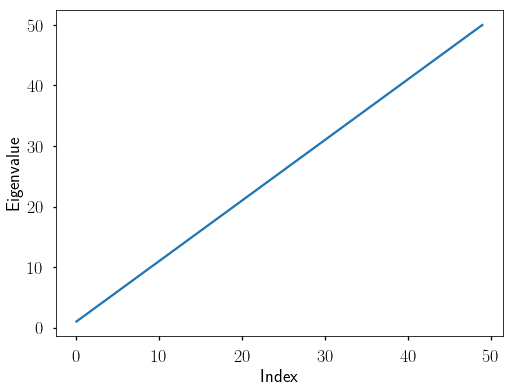

In [2]:
n = 50
D = np.arange(1, n+1)
U = np.random.randn(n, n)
U, _ = np.linalg.qr(U)
A = U.dot(np.diag(D)).dot(U.T)
b = np.random.randn(n)
eig_vals = np.linalg.eigvals(A)
print("Condition number = {}".format(np.max(eig_vals) / np.min(eig_vals)))
plt.figure(figsize=figsize)
plt.plot(np.sort(eig_vals))
plt.xlabel("Index", fontsize=fontsize)
plt.ylabel("Eigenvalue", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [3]:
f = lambda x: 0.5 * x.T.dot(A.dot(x)) - b.dot(x)
grad_f = lambda x: A.dot(x) - b
hess_f = lambda x: A

In [4]:
m_dict = {
     "GD": solvers.fo.GradientDescent(f, grad_f, ss.ExactLineSearch4Quad(A, b)),
     "Newton": solvers.so.NewtonMethod(f, grad_f, hess_f, ss.ExactLineSearch4Quad(A, b)),
     "CG quad": solvers.fo.ConjugateGradientQuad(A, b),
     "CG FR": solvers.fo.ConjugateGradientFR(f, grad_f, ss.Backtracking("Armijo", rho=0.5, beta=0.1, init_alpha=1.)),
     "BB 1": solvers.fo.BarzilaiBorweinMethod(f, grad_f, init_alpha=1e-4, type=1),
     "Nesterov": solvers.fo.AcceleratedGD(f, grad_f, ss.ConstantStepSize(2e-2))
    }

In [5]:
x0 = np.random.rand(n)
tol = 1e-6
max_iter = 100

In [6]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=True)

	 GD
Convergence in 100 iterations
Norm of gradient = 0.010430269600667758
Function value = -2.054877405126713
	 Newton
Convergence in 1 iterations
Norm of gradient = 4.357674996064246e-14
Function value = -2.0549024527646
	 CG quad
Convergence in 36 iterations
Norm of gradient = 6.623318641556426e-07
Function value = -2.05490245276459
	 CG FR
Convergence in 68 iterations
Norm of gradient = 8.12969910453874e-07
Function value = -2.054902452764572
	 BB 1
Convergence in 76 iterations
Norm of gradient = 9.72566516458749e-07
Function value = -2.0549024527642707
	 Nesterov
Convergence in 100 iterations
Norm of gradient = 0.004398003905197171
Function value = -2.0548951725309283


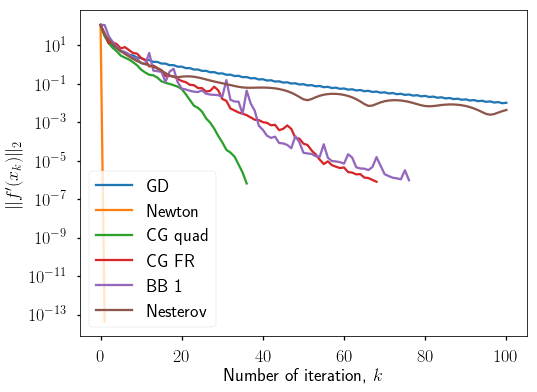

In [7]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
plt.legend(fontsize=18)
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [8]:
for key in m_dict:
    print("\t {}".format(key))
    %timeit m_dict[key].solve(x0, max_iter, tol)

	 GD
1.75 ms ± 137 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 Newton
53.8 µs ± 2.56 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
	 CG quad
644 µs ± 18.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 CG FR
4.89 ms ± 193 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 BB 1
1.11 ms ± 92.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 Nesterov
1.38 ms ± 109 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Matrix with high condition number and clusterized spectrum

Condition number = 1000.0000000005502


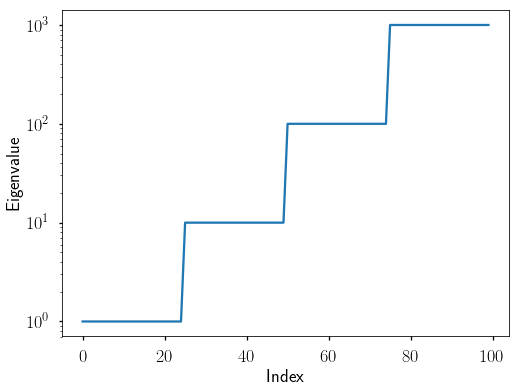

In [9]:
n = 100
A = np.diagflat([np.ones(n//4), 10 * np.ones(n//4), 100*np.ones(n//4), 1000* np.ones(n//4)])
U = np.random.rand(n, n)
Q, _ = np.linalg.qr(U)
A = Q.dot(A).dot(Q.T)
A = (A + A.T) * 0.5
b = np.random.randn(n)
eig_vals = np.linalg.eigvalsh(A)
print("Condition number = {}".format(max(eig_vals) / min(eig_vals)))
plt.figure(figsize=figsize)
plt.semilogy(np.sort(eig_vals))
plt.xlabel("Index", fontsize=fontsize)
plt.ylabel("Eigenvalue", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [10]:
f = lambda x: 0.5 * x.dot(A.dot(x)) - b.dot(x)
grad_f = lambda x: A.dot(x) - b
x0 = np.zeros(n)

In [14]:
m_dict = {
     "GD": solvers.fo.GradientDescent(f, grad_f, ss.ExactLineSearch4Quad(A, b)),
     "Newton": solvers.so.NewtonMethod(f, grad_f, hess_f, ss.ExactLineSearch4Quad(A, b)),
     "CG quad": solvers.fo.ConjugateGradientQuad(A, b),
     "CG FR": solvers.fo.ConjugateGradientFR(f, grad_f, ss.Backtracking("Wolfe strong", rho=0.5, beta1=0.1, beta2=0.7,
                                                                     init_alpha=1.), restarts.Restart(10)),
     "BB 1": solvers.fo.BarzilaiBorweinMethod(f, grad_f, init_alpha=1e-4, type=1),
     "Nesterov": solvers.fo.AcceleratedGD(f, grad_f, ss.ConstantStepSize(1e-3))
    }

In [15]:
x0 = np.random.rand(n)
tol = 1e-6
max_iter = 100

In [16]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=True)

	 GD
Convergence in 100 iterations
Norm of gradient = 10.255263750382857
Function value = -10.252108124025776
	 Newton
Convergence in 1 iterations
Norm of gradient = 1.0047896281897662e-12
Function value = -16.904587415099314
	 CG quad
Convergence in 5 iterations
Norm of gradient = 7.413852890460021e-11
Function value = -16.904587415099485
	 CG FR
Convergence in 100 iterations
Norm of gradient = 1.237106060074193
Function value = -16.621418657226595
	 BB 1
Convergence in 73 iterations
Norm of gradient = 3.0168392630049424e-07
Function value = -16.904587415099527
	 Nesterov
Convergence in 100 iterations
Norm of gradient = 0.927123383452045
Function value = -16.475672033388598


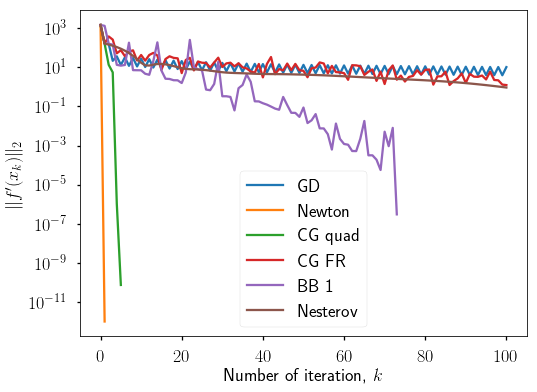

In [17]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
    plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)

In [18]:
for key in m_dict:
    print("\t {}".format(key))
    %timeit m_dict[key].solve(x0, max_iter, tol)

	 GD
2.61 ms ± 238 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 Newton
132 µs ± 2.01 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
	 CG quad
132 µs ± 3.33 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
	 CG FR
18 ms ± 721 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 BB 1
1.51 ms ± 102 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 Nesterov
1.89 ms ± 92.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Analytical center of the set of inequalities

In [19]:
n = 1000
m = 500
A = np.random.rand(n, m) * 10

In [20]:
f = lambda x: -np.sum(np.log(1 - A.T.dot(x))) - np.sum(np.log(1 - x*x))
grad_f = lambda x: np.sum(A.dot(np.diagflat(1 / (1 - A.T.dot(x)))), \
                          axis=1) + 2 * x / (1 - np.power(x, 2))

hess_f = lambda x: (A.dot(np.diagflat(1 / (1 - A.T.dot(x))**2))).dot(A.T) + np.diagflat(2 * (1 + x**2) / (1 - x**2)**2)

In [22]:
m_dict = {
     "GD": solvers.fo.GradientDescent(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "Newton": solvers.so.NewtonMethod(f, grad_f, hess_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "CG FR": solvers.fo.ConjugateGradientFR(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.), 
                                             restarts.Restart(10)),
     "BB 1": solvers.fo.BarzilaiBorweinMethod(f, grad_f, init_alpha=1e-4, type=1),
     "Nesterov": solvers.fo.AcceleratedGD(f, grad_f, ss.ConstantStepSize(3e-4))
    }

In [23]:
x0 = np.zeros(n)
tol = 1e-5
max_iter = 100

In [24]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=True)

	 GD


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


Convergence in 25 iterations
Norm of gradient = 7.415762348903135e-06
Function value = -3632.8385906211815
	 Newton
Convergence in 14 iterations
Norm of gradient = 1.5700575475929423e-08
Function value = -3632.838590621186
	 CG FR
Convergence in 17 iterations
Norm of gradient = 9.26063704208749e-06
Function value = -3632.8385906211784
	 BB 1
Convergence in 9 iterations
Norm of gradient = 6.676494162788471e-06
Function value = -3632.838590621181
	 Nesterov
Convergence in 100 iterations
Norm of gradient = 5.108382064089764
Function value = -3630.756286072171


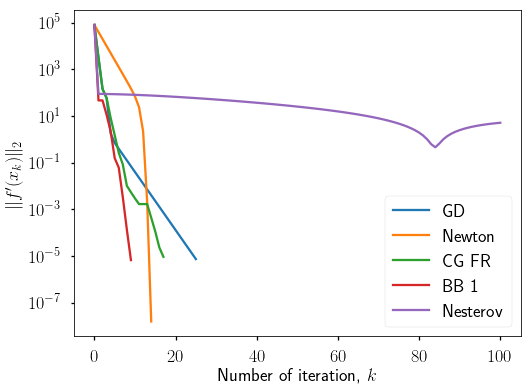

In [25]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)

In [ ]:
for key in m_dict:
    print("\t {}".format(key))
    %timeit m_dict[key].solve(x0, max_iter, tol)

## Toy logistic regression with L2 regularization

In [26]:
import numpy as np
import sklearn.datasets as skldata
import scipy.special as scspec

n = 300
m = 1000

X, y = skldata.make_classification(n_classes=2, n_features=n, n_samples=m, n_informative=n//3)
C = 1

def f(w):
    return np.linalg.norm(w)**2 / 2 +  C * np.mean(np.logaddexp(np.zeros(X.shape[0]), -y * X.dot(w)))

def grad_f(w):
    denom = scspec.expit(-y * X.dot(w))
    return w - C * X.T.dot(y * denom) / X.shape[0]

def hess_f(w):
    denom = scspec.expit(-y * X.dot(w))
    d = y**2 * denom**2
    return np.eye(n) + C * (X.T * d).dot(X) / X.shape[0]

x0 = np.zeros(n)
print("Initial function value = {}".format(f(x0)))
print("Initial gradient norm = {}".format(np.linalg.norm(grad_f(x0))))

Initial function value = 0.6931471805599454
Initial gradient norm = 2.165576145726932


In [27]:
m_dict = {
     "GD": solvers.fo.GradientDescent(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "Newton": solvers.so.NewtonMethod(f, grad_f, hess_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "CG FR": solvers.fo.ConjugateGradientFR(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.), 
                                             restarts.Restart(10)),
     "BB 1": solvers.fo.BarzilaiBorweinMethod(f, grad_f, init_alpha=1e-4, type=1),
     "Nesterov": solvers.fo.AcceleratedGD(f, grad_f, ss.ConstantStepSize(1e-2)),
    }

In [28]:
x0 = np.zeros(n)
tol = 1e-5
max_iter = 100

In [29]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=True)

	 GD
Convergence in 100 iterations
Norm of gradient = 0.005328323198866601
Function value = 0.4961077807892009
	 Newton
Convergence in 28 iterations
Norm of gradient = 5.419313117089153e-06
Function value = 0.49610127843112384
	 CG FR
Convergence in 63 iterations
Norm of gradient = 5.724983762047173e-06
Function value = 0.4961012784349531
	 BB 1
Convergence in 52 iterations
Norm of gradient = 8.242469553909469e-06
Function value = 0.4961012784577527
	 Nesterov
Convergence in 100 iterations
Norm of gradient = 0.0025001874596942497
Function value = 0.49610300200963936


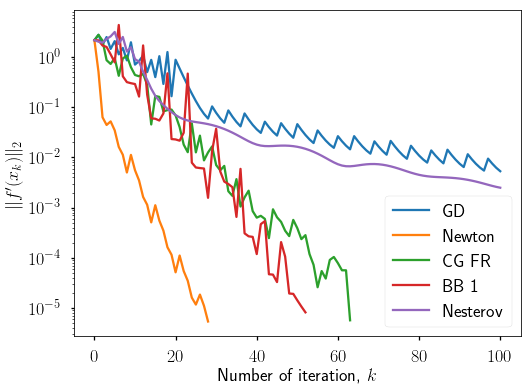

In [30]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
plt.legend(fontsize=fontsize)
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [ ]:
for key in m_dict:
    print("\t {}".format(key))
    %timeit m_dict[key].solve(x0, max_iter, tol)